Description: this notebook uses the pretrained Vision Transformer (ViT) model found on Hugging Face:
https://huggingface.co/google/vit-base-patch16-224-in21k

Data info:
I downselected the kaggle/microsoft cats and dogs dataset (removing a few mislabeled/irrelevant, cartoon, or malformed images)


Model info:
The ViT model is pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.

In this notebook, I add a 2 class (dog/cat) MLP head for classification of dogs and cats. I then finetune on the kaggle/microsoft dog and cat dataset.  I then check to see if this improves performance identifying our family cat as a cat. This is a surprisingly hard cat to distinguish using other pretrained models.


Code is partly based off https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb

# Get dataset of cats and dogs (downselected from kaggle) & test dataset of family and friends pets 


In [1]:
from datasets import load_dataset

folder_path = "data/"
ds = load_dataset('imagefolder', data_dir=folder_path) #use folder-based builder, ImageFolder to get dataset


#stored at ~/.cache/huggingface/datasets/imagefolder/default-3bfd8ee0dd5df467/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f

Resolving data files:   0%|          | 0/23381 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/57 [00:00<?, ?it/s]

Using custom data configuration default-3bfd8ee0dd5df467
Found cached dataset imagefolder (/home/dm/.cache/huggingface/datasets/imagefolder/default-3bfd8ee0dd5df467/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 23379
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 57
    })
})

In [3]:
#split microsoft/kaggle data into training and validation sets
splits = ds["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

#keep family photos as test data set (to check after training)
test_ds = ds["test"]

# Spot Check Data

In [4]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 21041
})

In [5]:
train_ds.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Cat', 'Dog'], id=None)}

In [6]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360>,
 'label': 1}

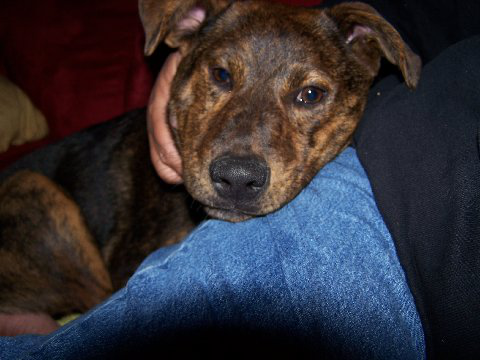

In [7]:
train_ds[0]["image"]

In [8]:
train_ds[0]["label"]

1

In [9]:
# training set -- note actual class name, rather than the integer index
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Cat', 1: 'Dog'}

In [10]:
id2label[train_ds[0]['label']]


'Dog'

In [11]:
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 2338
})

In [12]:
val_ds.features


{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Cat', 'Dog'], id=None)}

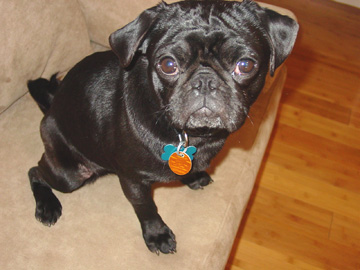

In [13]:
val_ds[0]['image']


In [14]:
val_ds[0]['label']


1

In [15]:
id2label[val_ds[0]['label']]


'Dog'

In [16]:
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 57
})

In [17]:
test_ds.features


{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Cat', 'Dog'], id=None)}

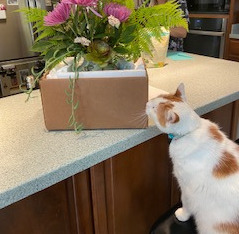

In [18]:
test_ds[0]['image']

In [19]:
test_ds[0]['label']

0

In [20]:
id2label[test_ds[0]['label']]

'Cat'

# Preprocess Data to Get into Right Tensor Form

In [21]:
from transformers import ViTFeatureExtractor, ViTModel

# default download dir is ~/.cache/huggingface/hub
processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


2023-05-08 09:29:03.030594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dm/miniconda3/envs/xformers/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [22]:
processor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [23]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [24]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [25]:
train_ds[:2] #check load of preprocessed images (on-the-fly)

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=279x500>],
 'label': [1, 1],
 'pixel_values': [tensor([[[-0.6784, -0.6863, -0.7333,  ..., -0.8353, -0.8196, -0.7961],
           [-0.4824, -0.5059, -0.5529,  ..., -0.8353, -0.8196, -0.7961],
           [-0.4196, -0.4275, -0.4510,  ..., -0.8275, -0.8118, -0.7961],
           ...,
           [-0.2863, -0.4431, -0.2784,  ..., -0.7098, -0.7020, -0.7098],
           [-0.4118, -0.4510, -0.4824,  ..., -0.7020, -0.7020, -0.7098],
           [-0.6078, -0.5451, -0.5529,  ..., -0.7098, -0.7020, -0.7098]],
  
          [[-0.7569, -0.7725, -0.8275,  ..., -1.0000, -1.0000, -1.0000],
           [-0.5922, -0.6314, -0.6863,  ..., -1.0000, -1.0000, -1.0000],
           [-0.5765, -0.5922, -0.6157,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [ 0.0353, -0.1216,  0.0353,  ..., -0.7569, -0.7490, -0.7647],
           [-0.0902, -0.1294, -0.1686,  ..., -0.7569, -0

In [26]:
# create a corresponding PyTorch DataLoader

from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [27]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)
     

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# Load Pre-trained Model and Set Up New Classifier Head

In [28]:
from transformers import ViTForImageClassification


#specify the number of output neurons by setting the id2label and label2id mapping
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
#print model and check that classifier has 2 out_features

print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

# Instantiate a Trainer

In [30]:

from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cats_vs_dogs",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [31]:
#define a compute_metrics function for evaluation. use "accuracy"
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [32]:
#build trainer
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

# Train

In [33]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

In [34]:
trainer.train()

/home/dm/miniconda3/envs/xformers/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 21041
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 6315
  Number of trainable parameters = 85800194


Epoch,Training Loss,Validation Loss,Accuracy
1,0.062100,0.012152,0.997434
2,0.038900,0.010477,0.997861
3,0.034700,0.010258,0.997861


***** Running Evaluation *****
  Num examples = 2338
  Batch size = 4
Saving model checkpoint to test-cats_vs_dogs/checkpoint-2105
Configuration saved in test-cats_vs_dogs/checkpoint-2105/config.json
Model weights saved in test-cats_vs_dogs/checkpoint-2105/pytorch_model.bin
Image processor saved in test-cats_vs_dogs/checkpoint-2105/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2338
  Batch size = 4
Saving model checkpoint to test-cats_vs_dogs/checkpoint-4210
Configuration saved in test-cats_vs_dogs/checkpoint-4210/config.json
Model weights saved in test-cats_vs_dogs/checkpoint-4210/pytorch_model.bin
Image processor saved in test-cats_vs_dogs/checkpoint-4210/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2338
  Batch size = 4
Saving model checkpoint to test-cats_vs_dogs/checkpoint-6315
Configuration saved in test-cats_vs_dogs/checkpoint-6315/config.json
Model weights saved in test-cats_vs_dogs/checkpoint-6315/pytorch_model.bin
Image p

TrainOutput(global_step=6315, training_loss=0.05130586344763483, metrics={'train_runtime': 29652.8465, 'train_samples_per_second': 2.129, 'train_steps_per_second': 0.213, 'total_flos': 4.891526860441891e+18, 'train_loss': 0.05130586344763483, 'epoch': 3.0})

In [35]:
#save model for later use

trainer.save_model()

Saving model checkpoint to test-cats_vs_dogs
Configuration saved in test-cats_vs_dogs/config.json
Model weights saved in test-cats_vs_dogs/pytorch_model.bin
Image processor saved in test-cats_vs_dogs/preprocessor_config.json
